# Real Time Bidding with Stochastic Optimal Control
In this notebook we implement part of the paper [Optimal Real-Time Bidding Strategies](https://arxiv.org/abs/1511.08409) by Fernandez-Tapia et al. 2016.

The setting is that a Demand Side Platform (DSP) is running a campaign with a given time horizon and a given budget. The goal is to maximize the number of impressions obtained during the alloted time while staying on budget.

## The Model
Our agent participates in a second price auction environment. Bid requests arrive at the exchange at random times, their arrival count can be modeled as a Poisson Process of constant rate $\lambda$. Then the other particpants post their bids for the advertisement space, we don't model each of them individually, rather we suppose we know the distribution of their bids. As we win bids our remaining cash decreases and our inventory increases. 

The model can be summarized as follows, with some reference values for the different parameters:  
* Bid request arrival process: 
   * $N_t \sim Poisson(\lambda t)$
   * $\lambda = 10^3$ bid requests/second
* Best bid among other participants : 
   * $p_{N_t} \sim Exp(\mu)$
   * $\mu = 2 \cdot 10^3$ (corresponding to a mean bid of 0.0005 euro) 
* Remaining cash process:
   * $S_0 = \bar{S} = 500 euro$ (initial budget)
   * $dS_t = -p_{N_t}\mathbb{1}_{(b_t>p_{N_t})}d{N_t}$, where $b_t$ is our bid
* Inventory process: 
   * $I_0 = 0$ (initial inventory)
   * $dI_t = \mathbb{1}_{(b_t>p_{N_t})}d{N_t}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

We start with a pretty straightforward implementation of the simulation environment:
* We'll make our first agent naive, always posting the mean bid. 
* We'll take pretty small steps and treat the Poisson process as the limit of a Bernoulli process: if bid requests arrive with a frequency of $\lambda$ requests per second then the probability of observing a bid request arrive in $dt$ seconds (for $dt$ small) is $\lambda dt$.

In [4]:
def run_sim(T, dt, lam, mu, budget):
    mean_bid = 1./mu
    cash_process = [budget]
    inventory_process = [0]
    t = 0
    times = [t]
    while t < T:
        curr_cash = cash_process[-1]
        curr_inventory = inventory_process[-1]
        arrival = np.random.binomial(n=1, p=lam*dt)
        if arrival:
            my_bid = mean_bid #or sthg else
            best_bid = np.random.exponential(scale=mean_bid)
            if my_bid > best_bid:
                curr_cash = cash_process[-1] - best_bid
                curr_inventory = inventory_process[-1] + 1
        cash_process.append(curr_cash)
        inventory_process.append(curr_inventory)
        t+=dt
        times.append(t)
        
    return {"times":np.array(times), "cash_process": np.array(cash_process), "inventory_process": np.array(inventory_process)}

In [8]:
T = 1 #final time in seconds
dt = 1e-6
lam = 1e3
mu = 2*1e3
budget = 500

In [9]:
%timeit res = run_sim(T, dt, lam, mu, budget)

3.37 s ± 9.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's a bit too slow for experimenting. Typically I'd vectorize it but I've been wanting to use just in time compilation more. So let's use numba to speed up that code.

In [19]:
from numba import jit

@jit
def run_sim_jit(T, dt, lam, mu, budget):
    mean_bid = 1./mu
    N = int(T/dt)
    times = np.linspace(0,T, N)
    cash_process = np.zeros(N)
    cash_process[0] = budget
    inventory_process = np.zeros(N)
    for i in range(N-1):
        curr_cash = cash_process[i]
        curr_inventory = inventory_process[i]
        arrival = np.random.binomial(n=1, p=lam*dt)
        if arrival:
            my_bid = mean_bid #or sthg else
            best_bid = np.random.exponential(scale=mean_bid)
            if my_bid > best_bid:
                curr_cash = cash_process[i] - best_bid
                curr_inventory = inventory_process[i] + 1
        cash_process[i+1] = curr_cash
        inventory_process[i+1] = curr_inventory
        
    return times, cash_process, inventory_process

In [18]:
#before adding jit decorator: 3.37 s
%timeit res = run_sim_jit(T, dt, lam, mu, budget)

3.37 s ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
#after adding jit decorator: 38 ms
%timeit res = run_sim_jit(T, dt, lam, mu, budget)

37.8 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Great, got it down form 3.4 seconds to 38 milliseconds. Now we can afford running it longer.

In [28]:
T = 100 #final time in seconds
dt = 1e-4
lam = 1e3
mu = 2*1e3
budget = 500
times, cash, inventory = run_sim_jit(T, dt, lam, mu, budget)

Text(0, 0.5, 'remaining cash (euro)')

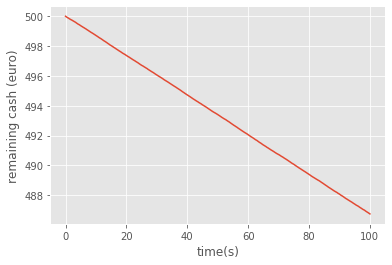

In [29]:
plt.plot(times, cash)
plt.xlabel('time(s)')
plt.ylabel('remaining cash (euro)')

Text(0, 0.5, 'Acquired inventory')

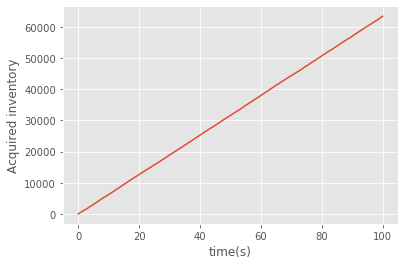

In [30]:
plt.plot(times, inventory)
plt.xlabel('time(s)')
plt.ylabel('Acquired inventory')

Text(0, 0.5, 'Acquired inventory')

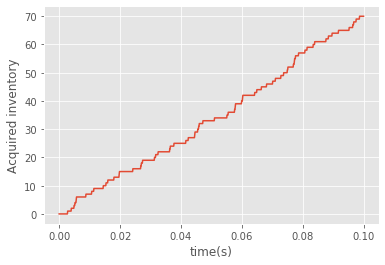

In [32]:
#zooming in:
plt.plot(times[:1000], inventory[:1000])
plt.xlabel('time(s)')
plt.ylabel('Acquired inventory')

Now let's use the bidding strategy from the paper. It's outlined in section 2.3.2.

![image](./sol_eqns.PNG "sol")

where $H'$ is given by

![](hprime.PNG "")

and $f$ is in our case the density of $Exp(\mu)$.

I could compute $H'$ analytically but not its reciprocal, so I implemented it numerically via rootfinding at the end of the notebook. 

In [99]:
@jit
def run_sim_tapia(T, dt, lam, mu, budget):
    mean_bid = 1./mu
    N = int(T/dt)
    times = np.linspace(0,T, N)
    cash_process = np.zeros(N)
    cash_process[0] = budget
    inventory_process = np.zeros(N)
    num_auctions = 0
    my_bids, best_bids = np.zeros(N), np.zeros(N)
    for i in range(N-1):
        curr_cash = cash_process[i]
        curr_inventory = inventory_process[i]
        arrival = np.random.binomial(n=1, p=lam*dt)
        if arrival:
            num_auctions+=1
            #section 2.3.2 from the paper
            expected_num_auctions = lam*(T-times[i])
            if curr_cash > expected_num_auctions * mean_bid:
                my_bid = budget # it's +infinity in the paper but it wouldnt make sense to bid more than we have as a budget in practice
            else:
                # we don't have an analytical expression for the inverse of hprime, 
                # but a numerical implementation is at the end of the notebook
                hpinv = hprime_inverse(curr_cash/(T-times[i]))
                my_bid = -1./hpinv 
            best_bid = np.random.exponential(scale=mean_bid)
            if my_bid > best_bid:
                curr_cash = cash_process[i] - best_bid
                curr_inventory = inventory_process[i] + 1
            my_bids[i] = my_bid
            best_bids[i] = best_bid
        cash_process[i+1] = curr_cash
        inventory_process[i+1] = curr_inventory
        
    return times, cash_process, inventory_process, num_auctions, my_bids, best_bids

/home/alejandro/.conda/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Text(0, 0.5, 'remaining cash (euro)')

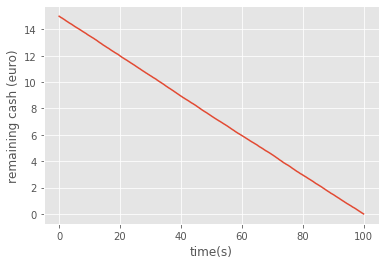

In [123]:
T = 100 #final time in seconds
dt = 1e-4
lam = 1e3
mu = 2*1e3
budget = 15
times, cash, inventory, num_actions, my_bids, best_bids = run_sim_tapia(T, dt, lam, mu, budget)
plt.plot(times, cash)
plt.xlabel('time(s)')
plt.ylabel('remaining cash (euro)')

Look at that! It takes the budget exactly down to zero in the alloted time. A naive agent would either stay way below and lose impressions or run out of budget too early and also lose impressions. The optimal control agent does it perfectly. Of course here we suppose we know the environment perfectly well which in practice won't really happen. Furthermore just winning as many impressions as possible is not the ultimate goal of DSPs.

In the rest of the notebook we inspect more in detail the bidding behavior of this strategy. We can see in particular how the bidding radically changes and spending increases at the end of the horizon. 

In [124]:
num_actions

99885

In [125]:
inventory[-1] 

66611.0

In [126]:
inventory[-1]/num_actions

0.6668769084447114

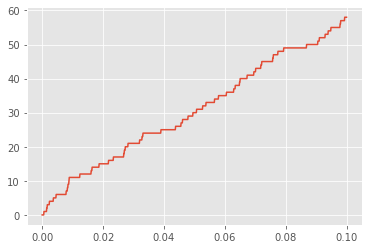

In [127]:
sec = 0.1
plt.plot(times[times<sec], inventory[times<sec])

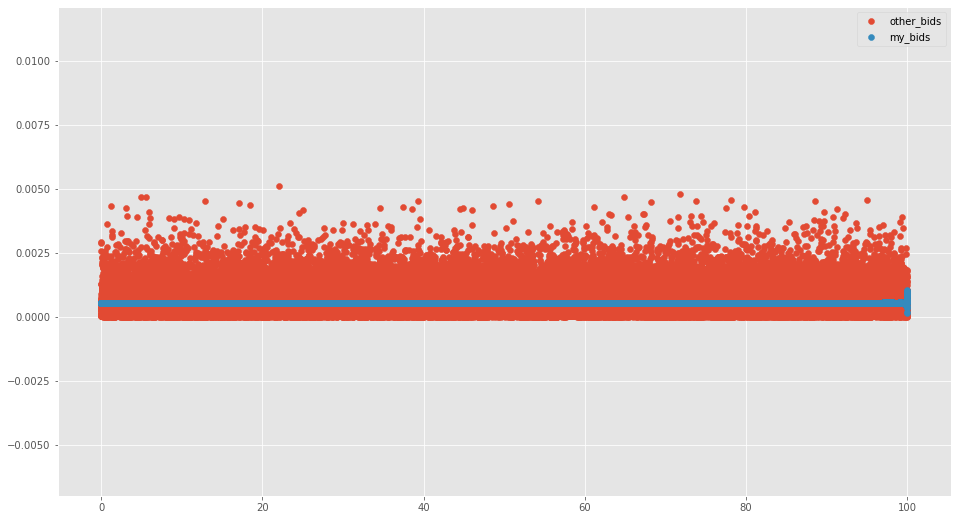

In [128]:
fig = plt.figure(figsize=(16,9))
plt.scatter(times[best_bids>0], best_bids[best_bids>0], label='other_bids')
plt.scatter(times[best_bids>0], my_bids[best_bids>0], label='my_bids')
plt.legend()

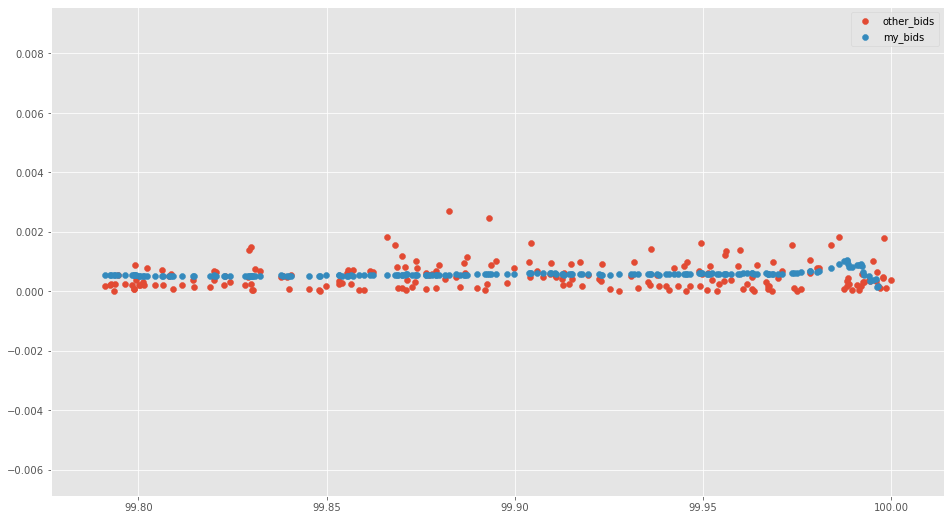

In [132]:
num = 200
fig = plt.figure(figsize=(16,9))
plt.scatter(times[best_bids>0][-num:], best_bids[best_bids>0][-num:], label='other_bids')
plt.scatter(times[best_bids>0][-num:], my_bids[best_bids>0][-num:], label='my_bids')
plt.legend()

No handles with labels found to put in legend.


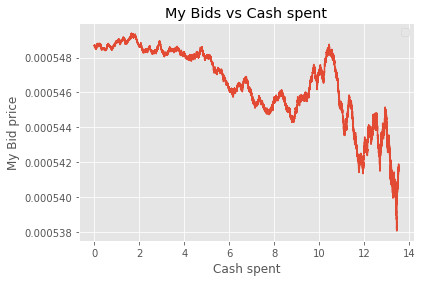

In [159]:
num = 90000
plt.plot(budget - cash[best_bids>0][:num], my_bids[best_bids>0][:num])
plt.title('My Bids vs Cash spent')
plt.xlabel('Cash spent')
plt.ylabel('My Bid price')
#plt.hlines(y=1/mu, xmin=cash[best_bids>0][:num].min(), xmax = cash[best_bids>0][:num].max(), label='average bid price')
plt.legend()

No handles with labels found to put in legend.


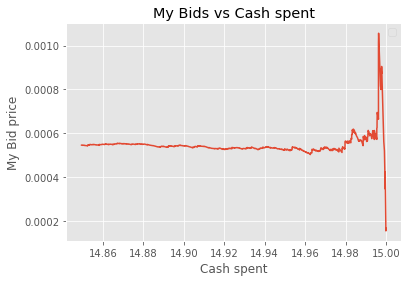

In [162]:
num = 1000
plt.plot(budget - cash[best_bids>0][-num:], my_bids[best_bids>0][-num:])
plt.title('My Bids vs Cash spent')
plt.xlabel('Cash spent')
plt.ylabel('My Bid price')
#plt.hlines(y=1/mu, xmin=cash[best_bids>0][:num].min(), xmax = cash[best_bids>0][:num].max(), label='average bid price')
plt.legend()

In [161]:
cash[-1]

-8.545820700750316e-05

In [42]:
xx = np.linspace(-100,100)

def hprime(x):
    res = np.zeros_like(x)
    res[x>=0] = lam/mu
    xneg = x[x<0]
    res[x<0] = lam * (np.exp(mu/xneg)*(1/xneg - 1/mu) + 1/mu)
    return res
hp = hprime(xx)

Text(0.5, 1.0, 'H prime')

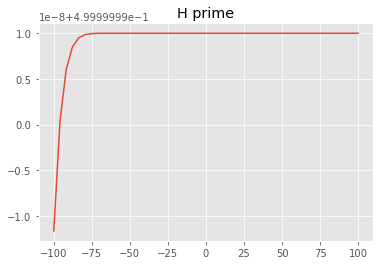

In [45]:
plt.plot(xx, hp)
plt.title('H prime')

In [47]:
-1/mu

-0.0005

In [48]:
from scipy.optimize import fsolve

In [95]:
def residual(x,y):
    return hprime(x)-y

def hprime_inverse(y):
    res, dic, ier, msg = fsolve(residual, x0=np.sqrt(lam/y), args=(y), full_output=True)
    #print(res)
    #print(dic)
    #print(ier, msg)
    return res[0]

In [96]:
y = 1
hprime_inverse(y)

31.622776601683793

In [97]:
ys = np.linspace(0.01, lam/mu, 1000)
inverses = []
for y in ys:
    inverses.append(hprime_inverse(y))

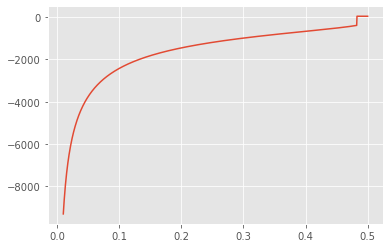

In [98]:
plt.plot(ys, inverses)

In [84]:
lam/mu

0.5